# How to use a cohort
This notebook shows how to use a cohort saved from Data Explorer.

It uses a cohort saved in the [Terra Notebooks Playground workspace](https://app.terra.bio/#workspaces/help-gatk/Terra%20Notebooks%20Playground/data).

# Setup

In [1]:
library(reticulate)
library(bigrquery)
library(ggplot2)

In [2]:
BILLING_PROJECT_ID <- Sys.getenv('GOOGLE_PROJECT')

# Get the cohort query

If you look at the data tab in workspace [Terra Notebooks Playground](https://app.terra.bio/#workspaces/help-gatk/Terra%20Notebooks%20Playground/data) you can see that someone used [data explorer web user interface](https://test-data-explorer.appspot.com/) to define and create a cohort containing a subset of the samples in the 1,000 Genomes dataset.

In this notebook we use the [firecloud api](https://api.firecloud.org/) to programmatically retrieve the definition of that cohort. This returns an auto generated SQL query which was the result of the users interaction with Data Explorer.


In [3]:
fapi <- import('firecloud.api')

In [4]:
# Hard-code instead of use WORKSPACE_NAMESPACE/WORKSPACE_NAME, since other workspaces
# won't have the 1000g_americans cohort.
ws_namespace <- 'help-gatk'
ws_name <- 'Terra Notebooks Playground'

cohort_query <- fapi$get_entity(ws_namespace, ws_name, 'cohort', '1000g_americans')$json()$attributes$query
print(cohort_query)

[1] "SELECT DISTINCT t1.participant_id FROM (SELECT participant_id FROM `verily-public-data.human_genome_variants.1000_genomes_participant_info` WHERE  ((Super_Population_Description = \"American\"))) t1"


# Call BigQuery

We then use the query from the cohort.

In [5]:
cohort_table <- bigrquery::bq_project_query(
    BILLING_PROJECT_ID,
    cohort_query
)
cohort_df <- bigrquery::bq_table_download(cohort_table)
dim(cohort_df)

[1] 535   1

In [6]:
head(cohort_df)

participant_id
<chr>
HG01433
HG01445
HG01452
HG01473
HG01482
HG01126


# Join with another table

In [7]:
query <- '
SELECT
    DISTINCT participant_id,
    Gender
FROM
    `verily-public-data.human_genome_variants.1000_genomes_participant_info`
'
cohort_info_table <- bigrquery::bq_project_query(
    BILLING_PROJECT_ID,
    query
)
cohort_info_df <- bigrquery::bq_table_download(cohort_info_table)
dim(cohort_info_df)

[1] 3500    2

In [8]:
merged_df <- merge(x = cohort_df, y = cohort_info_df, by = 'participant_id', all.x = TRUE)
dim(merged_df)

[1] 535   2

# Plot

In [9]:
table(merged_df$Gender)


female   male 
   293    242 

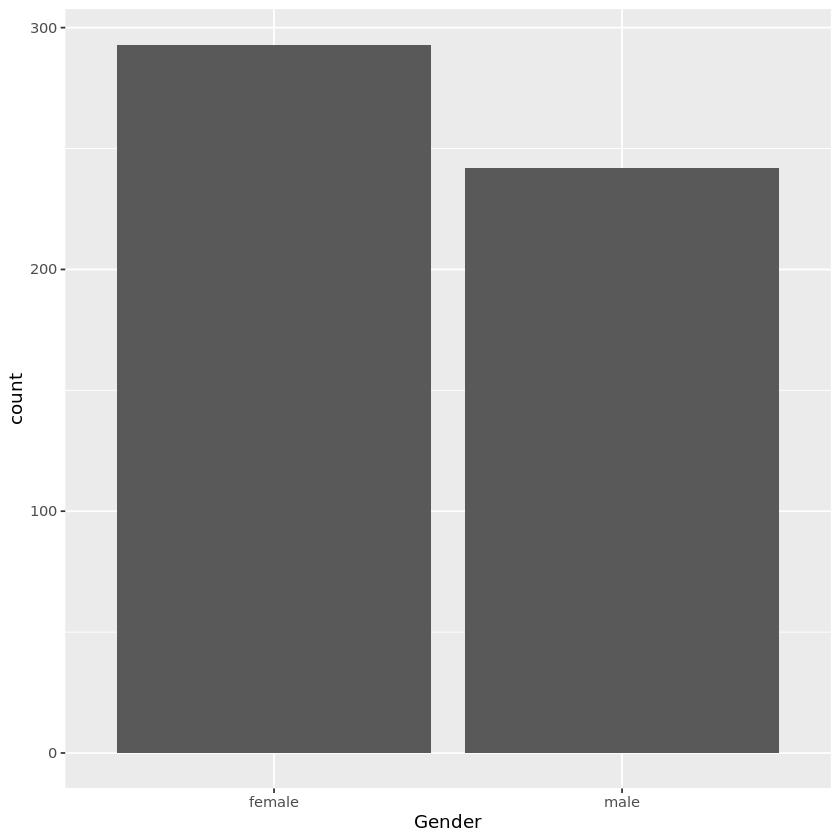

In [10]:
ggplot(merged_df, aes(Gender)) + geom_bar()

# Provenance

In [11]:
devtools::session_info()

─ Session info ───────────────────────────────────────────────────────────────
 setting  value                       
 version  R version 4.0.2 (2020-06-22)
 os       Ubuntu 18.04.4 LTS          
 system   x86_64, linux-gnu           
 ui       X11                         
 language (EN)                        
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       Etc/UTC                     
 date     2020-07-27                  

─ Packages ───────────────────────────────────────────────────────────────────
 package     * version  date       lib source        
 assertthat    0.2.1    2019-03-21 [2] CRAN (R 4.0.2)
 backports     1.1.8    2020-06-17 [2] CRAN (R 4.0.2)
 base64enc     0.1-3    2015-07-28 [2] CRAN (R 4.0.2)
 bigrquery   * 1.3.1    2020-05-15 [2] CRAN (R 4.0.2)
 bit           1.1-15.2 2020-02-10 [2] CRAN (R 4.0.2)
 bit64         0.9-7    2017-05-08 [2] CRAN (R 4.0.2)
 callr         3.4.3    2020-03-28 [2] CRAN (R 4.0.2)
 cli           2.0.

Copyright 2019 The Broad Institute, Inc., Verily Life Sciences, LLC All rights reserved.

This software may be modified and distributed under the terms of the BSD license. See the LICENSE file for details.